In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,roc_curve
import nltk
from nltk import pos_tag
from nltk.corpus import wordnet,stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re,string,unicodedata
from wordcloud import WordCloud,STOPWORDS
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D, Bidirectional, Dropout
from string import punctuation
import warnings
import pickle

In [2]:
warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_csv(r"C:\Users\antho\OneDrive\Desktop\Data_Science\Project\sentimental_analysis\sentiment_data\Train.csv",encoding='latin-1')
df_test = pd.read_csv(r"C:\Users\antho\OneDrive\Desktop\Data_Science\Project\sentimental_analysis\sentiment_data\Test.csv",encoding='latin-1')

In [4]:
df_train.head()

,ï»¿Text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [5]:
df_test.head()

,ï»¿text,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0


In [6]:
df_train.rename(columns={'ï»¿Text':'review'},inplace=True) 
df_test.rename(columns={'ï»¿text':'review'},inplace=True) 

In [7]:
df_train.head()

,review,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [8]:
df_test.head()

,review,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0


In [9]:
df_train.shape

(40000, 2)

In [10]:
df_test.shape

(5000, 2)

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [12]:
def count_word(text):
    words = text.split()
    word_count = len(words)
    return word_count

In [13]:
df_train["word_count"] = df_train["review"].apply(count_word)

In [14]:
df_train.head()

,review,label,word_count
0,I grew up (b. 1965) watching and loving the Th...,0,151
1,"When I put this movie in my DVD player, and sa...",0,326
2,Why do people who do not know what a particula...,0,184
3,Even though I have great interest in Biblical ...,0,69
4,Im a die hard Dads Army fan and nothing will e...,1,178


In [15]:
stop_words = stopwords.words('english')
new_stopwords = ["movie","one","would","shall","could","might","Im"]
stop_words.extend(new_stopwords)
stop_words.remove("not")
stop_words = set(stop_words)

In [16]:
#remove special charcter

def remove_splchar(content):
    return re.sub('\[[^&@#!]]*/]',' ',content)

# remove url
def remove_url(content):
    return re.sub(r"http\S+|www\S+|https\S+",' ',content)

#remove stopwords from text
def remove_stopword(content):
    data=[]
    for i in content.split():
        if i.strip().lower() not in stop_words and i.strip().lower().isalpha():
            data.append(i.strip().lower())
    return " ".join(data)

#expantion of english contraction
def contract_extract(content):
    content = re.sub(r"won\'t", "would not", content)
    content = re.sub(r"can\'t", "can not ", content)
    content = re.sub(r"don\'t", "do not ", content)
    content = re.sub(r"shouldn\'t", "should not ", content)
    content = re.sub(r"needn\'t", "need not ", content)
    content = re.sub(r"hasn\'t", "has not ", content)
    content = re.sub(r"haven\'t", "have not ", content)
    content = re.sub(r"weren\'t", "were not ", content)
    content = re.sub(r"mightn\'t", "might not ", content)
    content = re.sub(r"didn\'t", "did not ", content)
    content = re.sub(r"aren\'t", "are not ", content)
    content = re.sub(r"isn\'t", "is not ", content)
    content = re.sub(r"wouldn\'t", "would not ", content)
    content = re.sub(r"willn\'t", "will not ", content)
    content = re.sub(r"\'t", "not ", content)
    content = re.sub(r"\'ve", "have ", content)
    content = re.sub(r"\'m", "am ", content)
    return content

def stemming(data):
    snowball = SnowballStemmer("english")
    snowball_stem = ' '.join([snowball.stem(word) for word in data])
    return data

 
def data_cleaning(content):
    content = remove_splchar(content)
    content = remove_url(content)
    content = contract_extract(content)
    content = remove_stopword(content)
    content = stemming(content)
    return content

In [17]:
df_train["clean_review"] = df_train["review"].apply(data_cleaning)
df_test["clean_review"] = df_test["review"].apply(data_cleaning)

In [18]:
df_train.head()

,review,label,word_count,clean_review
0,I grew up (b. 1965) watching and loving the Th...,0,151,grew watching loving mates school played lunch...
1,"When I put this movie in my DVD player, and sa...",0,326,put dvd sat coke hoping contain first awsome g...
2,Why do people who do not know what a particula...,0,184,people not know particular time past like feel...
3,Even though I have great interest in Biblical ...,0,69,even though great interest biblical bored deat...
4,Im a die hard Dads Army fan and nothing will e...,1,178,im die hard dads army fan nothing ever change ...


In [19]:
print(df_train["clean_review"][0],"\n")

grew watching loving mates school played lunch wanted virgil wanted counting became art took children see hoping get glimpse loved bitterly high point snappy theme not compare original score thankfully early saturday mornings television channel still plays reruns series gerry anderson wife jonatha frakes hand directors version completely waste utter cgi remake may acceptable replacing marionettes homo sapiens sapiens huge error 



In [20]:
duplicate_count = df_train.duplicated().sum()
print("Number of duplicate entries is : ",duplicate_count)

Number of duplicate entries is :  277


In [21]:
df_train = df_train.drop_duplicates("clean_review")

In [22]:
df_train.drop(columns = "review",inplace = True)

In [23]:
df_train.head()

,label,word_count,clean_review
0,0,151,grew watching loving mates school played lunch...
1,0,326,put dvd sat coke hoping contain first awsome g...
2,0,184,people not know particular time past like feel...
3,0,69,even though great interest biblical bored deat...
4,1,178,im die hard dads army fan nothing ever change ...


In [24]:
df_test.head()

,review,label,clean_review
0,I always wrote this series off as being a comp...,0,always wrote series complete jim belushi invol...
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0,watched typical mary kate ashley fare looks li...
2,This movie was so poorly written and directed ...,0,poorly written directed fell asleep minutes jo...
3,The most interesting thing about Miryang (Secr...,1,interesting thing miryang jeon lee main woman ...
4,"when i first read about ""berlin am meer"" i did...",0,first read not expect thought right right righ...


In [25]:
pos_review = df_train[df_train["label"]==1]
pos_review.head()

,label,word_count,clean_review
4,1,178,im die hard dads army fan nothing ever change ...
6,1,239,finally watched shocking last disturbing unbel...
8,1,188,may remake tale eleven director mabel cheung m...
9,1,282,super ex girlfriend turned pleasant surprise r...
10,1,125,not believe people looking plot laural lighten...


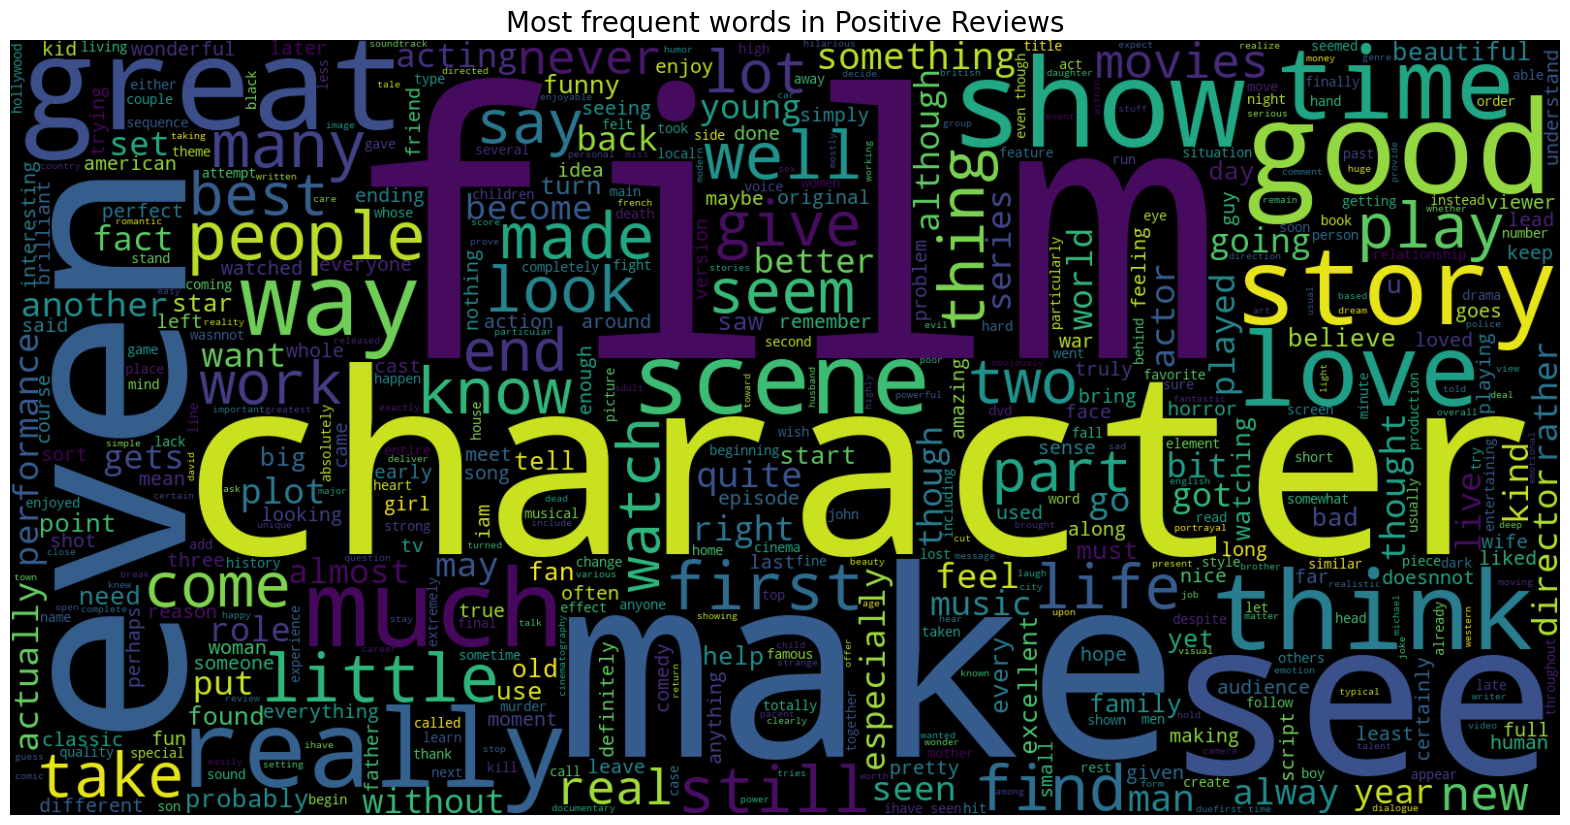

In [26]:
text = ' '.join([word for word in pos_review["clean_review"]])
plt.figure(figsize = (20,15),facecolor = "None")
wordcloud = WordCloud(max_words = 500, width = 1600, height = 800).generate(text)
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.title("Most frequent words in Positive Reviews", fontsize = 20)
plt.show()

In [27]:
neg_review = df_train[df_train["label"] == 0]
neg_review.head()

,label,word_count,clean_review
0,0,151,grew watching loving mates school played lunch...
1,0,326,put dvd sat coke hoping contain first awsome g...
2,0,184,people not know particular time past like feel...
3,0,69,even though great interest biblical bored deat...
5,0,102,terrible everyone made laugh cameo appearance ...


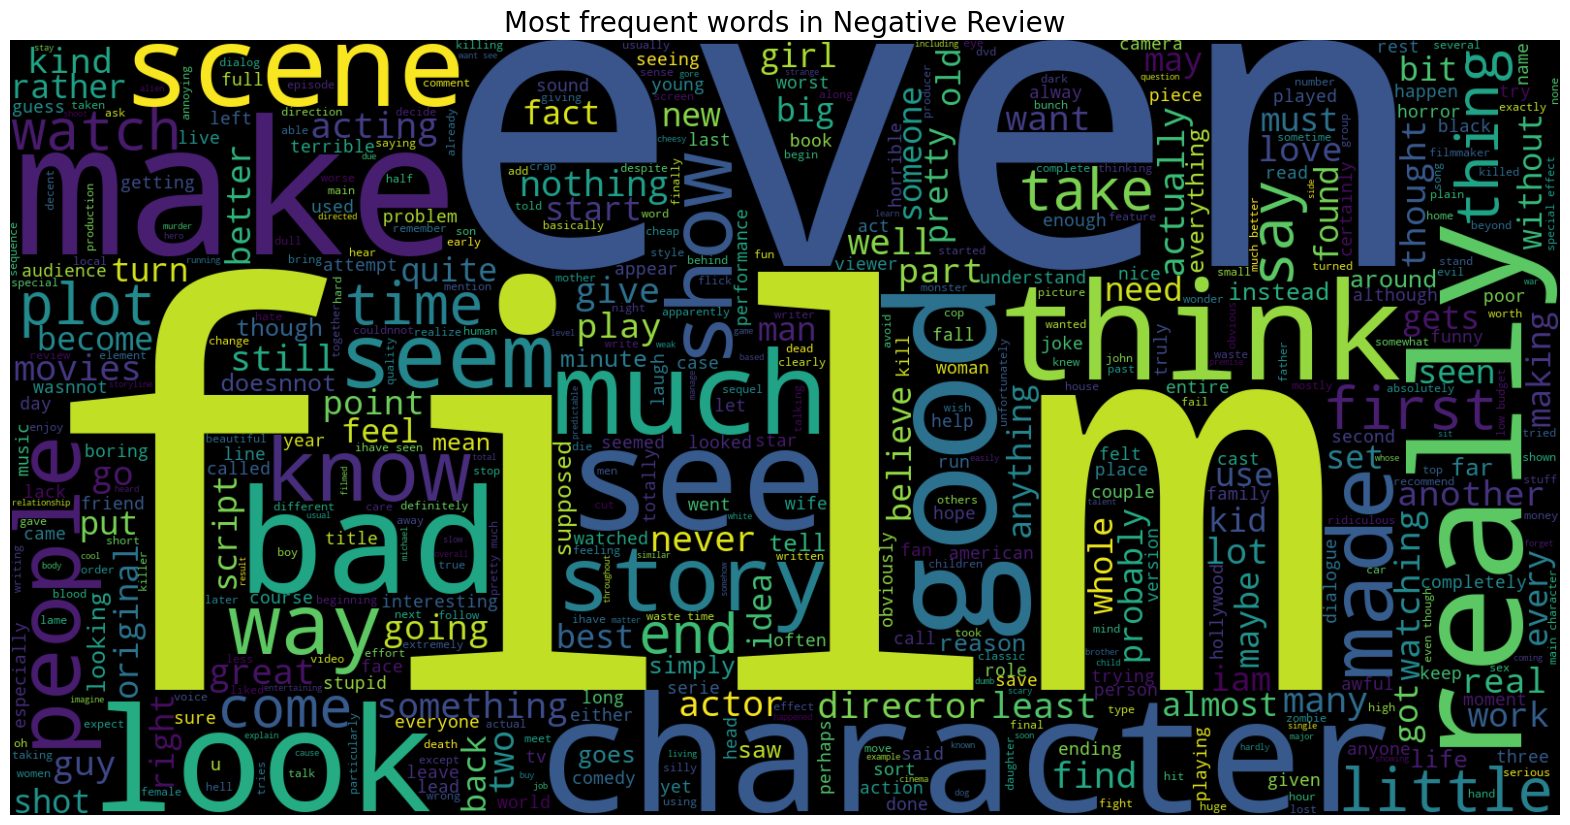

In [28]:
text = ' '.join([word for word in neg_review["clean_review"]])
plt.figure(figsize =(20,15),facecolor = "None")
wordcloud = WordCloud(max_words = 500, width = 1600 ,height = 800).generate(text)
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.title("Most frequent words in Negative Review", fontsize = 20)
plt.show()

In [29]:
X_train = df_train["clean_review"]
y_train = df_train["label"]
X_test = df_test["clean_review"]
y_test = df_test["label"]

In [30]:
X_train.head()

0    grew watching loving mates school played lunch...
1    put dvd sat coke hoping contain first awsome g...
2    people not know particular time past like feel...
3    even though great interest biblical bored deat...
4    im die hard dads army fan nothing ever change ...
Name: clean_review, dtype: object

In [31]:
y_train.head

<bound method NDFrame.head of 0        0
1        0
2        0
3        0
4        1
        ..
39995    1
39996    1
39997    0
39998    1
39999    1
Name: label, Length: 39718, dtype: int64>

In [32]:
# Tokenizing and padding sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_seq, maxlen=100)

In [33]:
print("Size of the x_train : ",X_train.shape)
print("Size of the y_train : ",y_train.shape)
print("Size of the x_test : ",X_test.shape)
print("Size of the y_test : ",y_test.shape)

Size of the x_train :  (39718,)
Size of the y_train :  (39718,)
Size of the x_test :  (5000,)
Size of the y_test :  (5000,)


In [34]:
X_train_seq

[[1560,
  48,
  1472,
  283,
  128,
  262,
  262,
  563,
  471,
  312,
  419,
  7,
  973,
  8,
  2334,
  243,
  177,
  129,
  631,
  1,
  1190,
  111,
  492,
  2984,
  224,
  1899,
  587,
  1119,
  35,
  144,
  139,
  2408,
  250,
  622,
  823,
  205,
  169,
  260,
  1501,
  1424,
  916,
  77,
  3312,
  380],
 [126,
  185,
  1258,
  973,
  2160,
  14,
  5,
  202,
  449,
  106,
  157,
  1,
  109,
  175,
  670,
  1,
  201,
  722,
  363,
  30,
  14,
  306,
  3119,
  705,
  14,
  47,
  1357,
  1104,
  826,
  412,
  1375,
  121,
  486,
  17,
  4778,
  14,
  449,
  96,
  2276,
  1,
  3062,
  1399,
  3,
  449,
  497,
  733,
  651,
  534,
  691,
  11,
  66,
  3,
  146,
  584,
  437,
  10,
  70,
  101,
  4510,
  1,
  5,
  346,
  437,
  158,
  219,
  1,
  30,
  14,
  1,
  133,
  300,
  482,
  686,
  608,
  235,
  3,
  1,
  35,
  214,
  60,
  261,
  1515,
  5,
  254,
  1,
  40,
  826,
  139,
  936],
 [16,
  1,
  28,
  651,
  12,
  421,
  3,
  102,
  178,
  186,
  12,
  3825,
  2068,
  228,
  4817

In [35]:
# Building the LSTM model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))  
model.add(SpatialDropout1D(0.2)) 
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [36]:
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_data=(X_test_padded, y_test), verbose=2)

Epoch 1/5
621/621 - 60s - 97ms/step - accuracy: 0.8168 - loss: 0.4053 - val_accuracy: 0.8546 - val_loss: 0.3546
Epoch 2/5
621/621 - 60s - 97ms/step - accuracy: 0.8693 - loss: 0.3157 - val_accuracy: 0.8604 - val_loss: 0.3326
Epoch 3/5
621/621 - 70s - 113ms/step - accuracy: 0.8842 - loss: 0.2809 - val_accuracy: 0.8642 - val_loss: 0.3433
Epoch 4/5
621/621 - 55s - 88ms/step - accuracy: 0.8970 - loss: 0.2529 - val_accuracy: 0.8520 - val_loss: 0.3534
Epoch 5/5
621/621 - 50s - 81ms/step - accuracy: 0.9089 - loss: 0.2262 - val_accuracy: 0.8562 - val_loss: 0.3681


In [41]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 100, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        91,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,195,105 (8.37 MB)

 Trainable params: 731,701 (2.79 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,463,404 (5.58 MB)

In [37]:
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Precision Score:", precision_score(y_test, y_pred))
print("Recall Score:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.86      2495
           1       0.87      0.84      0.85      2505

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000

Accuracy Score: 0.8562
Precision Score: 0.8696192052980133
Recall Score: 0.8387225548902195
F1 Score: 0.8538914854704328


In [38]:
# Predicting on new text data
def predict_sentiment(text):
    # Clean and preprocess text
    text = data_cleaning(text)
    text_seq = tokenizer.texts_to_sequences([text])
    text_padded = pad_sequences(text_seq, maxlen=100)
    prediction = (model.predict(text_padded) > 0.5).astype("int32")
    return "Positive" if prediction[0][0] == 1 else "Negative"
    
new_text = "The movie super"
print("Prediction for new text:", predict_sentiment(new_text))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Prediction for new text: Positive
